In [1]:
import pandas as pd
import numpy as np
import pickle
from pandas import Timestamp
from collections import Counter
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve, auc
import sys
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

## Load data and clean

In [2]:
sessions = pickle.load(open('../Data/sessions.pkl', 'rb'))
events = pd.read_csv('../Data/events.csv')

In [3]:
sessions.head()

,session_id,start_timestamp,timezone,timezone_offset,previous_sessions_duration,user_created_timestamp,is_user_first_session,is_session,country,region,city,latitude,longitude,locale,os_name,session_index,device_id,user_id_hash
0,5558845121177764917,1542215364580,Asia/Manila,28800000,25837591,1538874289458,False,True,PH,00,makati,14.554729,121.024445,en_GB,Android OS,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,2201961907282901522,1543712977293,Asia/Manila,28800000,35050130,1538874289458,False,True,PH,00,quezon city,14.676041,121.043701,en_GB,Android OS,47,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,18781111175537580,1539215568666,Asia/Manila,28800000,11343848,1538874289458,False,True,PH,00,makati,14.554729,121.024445,en_GB,Android OS,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,1477540082628742048,1540120743010,Asia/Manila,28800000,13499724,1538874289458,False,True,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,8184875317380844086,1542671625528,Asia/Manila,28800000,32788010,1538874289458,False,True,PH,00,makati,14.554729,121.024445,en_GB,Android OS,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [4]:
events.head()

,app_id,session_id,event,event_timestamp,event_value,user_id_hash
0,4724682771660800,5558845121177764917,45,1542215397132,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,4724682771660800,5558845121177764917,45,1542215484895,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,4724682771660800,7689508378645584666,.m5100869650219008,1541124410372,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,4724682771660800,2201961907282901522,4,1543713091129,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,4724682771660800,2201961907282901522,6,1543713093116,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [5]:
sessions = sessions.drop(['timezone_offset', 'timezone', 'is_user_first_session', 'city', 'region',
                        'latitude', 'longitude', 'locale', 'device_id'], axis=1).dropna()
sessions = sessions[sessions['is_session']==True].drop('is_session', axis=1)
sessions['start_timestamp'] = pd.to_datetime(sessions['start_timestamp'], unit='ms')
sessions['user_created_timestamp'] = pd.to_datetime(sessions['user_created_timestamp'], unit='ms')
sessions = sessions.sort_values(by='start_timestamp')
sessions = sessions.reset_index(drop=True)

In [6]:
events = events.drop('app_id', axis=1)
events = events[events['event'].map(lambda x: x[0]!='.')]
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'],unit='ms')
events = events.sort_values(by='event_timestamp')
events = events.reset_index(drop=True)

In [7]:
sessions.head()

,session_id,start_timestamp,previous_sessions_duration,user_created_timestamp,country,os_name,session_index,user_id_hash
0,4339488202460077611,2018-10-01 07:00:04.526,0,2018-10-01 07:00:04.526,AU,iPhone OS,1,c9bad12f865142f1b3938c9ab8a3003a7882136a2b4a12...
1,7012480646309837595,2018-10-01 07:00:08.476,0,2018-10-01 07:00:08.476,NZ,iOS,1,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
2,2920311224184894615,2018-10-01 07:01:02.101,1000637,2018-10-01 06:44:08.468,IN,Android OS,2,475f8f20576637055c5331513dda4db1d889f5e951c8e5...
3,8483277250870486701,2018-10-01 07:01:30.694,0,2018-10-01 07:01:30.694,US,Android OS,1,4bc7b52d56b24d258ba1746994492f354fd4b17fcaae81...
4,8114762104527844914,2018-10-01 07:01:57.770,2415582,2018-10-01 06:18:23.919,US,Android OS,2,82349b0d1a80b42e59519068ded46178778084b9602b9c...


In [8]:
events.head()

,session_id,event,event_timestamp,event_value,user_id_hash
0,7012480646309837595,44,2018-10-01 07:00:40.514,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
1,7012480646309837595,5,2018-10-01 07:00:42.744,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
2,7012480646309837595,45,2018-10-01 07:01:06.395,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
3,7012480646309837595,14,2018-10-01 07:01:44.065,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
4,4339488202460077611,44,2018-10-01 07:01:54.780,0.0,c9bad12f865142f1b3938c9ab8a3003a7882136a2b4a12...


In [9]:
print(len(sessions), len(events))

5157590 109627861


## Get data & label

In [12]:
events_data_val = events[np.logical_and(events['event_timestamp']
                                        <=(events.event_timestamp.iloc[-1] - pd.Timedelta(days=14)),
                                        events['event_timestamp']
                                        >(events.event_timestamp.iloc[0] + pd.Timedelta(days=14)))]
events_label_val = events[events['event_timestamp']>(events.event_timestamp.iloc[-1] - pd.Timedelta(days=14))]

In [13]:
events_data_train = events[events['event_timestamp']<=(events.event_timestamp.iloc[-1] - pd.Timedelta(days=28))]
events_label_train = events[np.logical_and(events['event_timestamp']
                                           >(events.event_timestamp.iloc[-1] - pd.Timedelta(days=28)),
                                           events['event_timestamp']
                                           <=(events.event_timestamp.iloc[-1] - pd.Timedelta(days=14)))]

In [14]:
sessions_data_val = sessions[np.logical_and(sessions['start_timestamp']
                                            <=(sessions.start_timestamp.iloc[-1]-pd.Timedelta(days=14)),
                                            sessions['start_timestamp']
                                            >(sessions.start_timestamp.iloc[0]+pd.Timedelta(days=14)))]
sessions_data_train = sessions[sessions['start_timestamp']<=(sessions.start_timestamp.iloc[-1]-pd.Timedelta(days=28))]

In [17]:
events_7_days_val = events_label_val[events_label['event_timestamp']
                                     <=(events.event_timestamp.iloc[-1] - pd.Timedelta(days=7))].\
                    groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_14_days_val = events_label_val.groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_7_days_val['user_purchase_binary_7_days'] = [int('8' in e) for e in events_7_days_val.event]
events_14_days_val['user_purchase_binary_14_days'] = [int('8' in e) for e in events_14_days_val.event]
val_label = events_14_days_val.merge(events_7_days_val, how='left', on='user_id_hash').fillna(0)
val_label = val_label.drop(['event_x', 'event_y'], axis=1)

### train & val labels

In [18]:
val_label.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0,0.0
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0,0.0
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0,0.0
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0,0.0
4,00020102f66f89759868c843ae9fe634870f132f9e3d79...,0,0.0


In [19]:
len(val_label)

84467

In [20]:
events_7_days_train = events_label_train[events_label_train['event_timestamp']
                                         <=(events_label_train.event_timestamp.iloc[-1] - pd.Timedelta(days=7))].\
                    groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_14_days_train = events_label_train.groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_7_days_train['user_purchase_binary_7_days'] = [int('8' in e) for e in events_7_days_train.event]
events_14_days_train['user_purchase_binary_14_days'] = [int('8' in e) for e in events_14_days_train.event]
train_label = events_14_days_train.merge(events_7_days_train, how='left', on='user_id_hash').fillna(0)
train_label = train_label.drop(['event_x', 'event_y'], axis=1)

In [21]:
train_label.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,000059859ec188af6035870faf885c3038cedda05b3a54...,1,1.0
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0,0.0
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0,0.0
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0,0.0
4,000161848e5ccdcd4d3b0c7be9ec844730c39e6bcbc2a7...,0,0.0


In [22]:
len(train_label)

208880

### train & val data

In [23]:
def get_training_data(df_data, df_label):
    return df_data[df_data['user_id_hash'].isin(df_label.user_id_hash)]

In [24]:
events_data_val = get_training_data(events_data_val, val_label)
sessions_data_val = get_training_data(sessions_data_val, val_label)
events_data_train = get_training_data(events_data_train, train_label)
sessions_data_train = get_training_data(sessions_data_train, train_label)

In [25]:
print(len(events_data_val), len(sessions_data_val))
print(len(events_data_train), len(sessions_data_train))

37831292 1767742
32300425 1491326


In [26]:
events_data_val = events_data_val.reset_index(drop=True)
sessions_data_val = sessions_data_val.reset_index(drop=True)
events_data_train = events_data_train.reset_index(drop=True)
sessions_data_train = sessions_data_train.reset_index(drop=True)

## Feature Engineering

In [27]:
def avg_diff(ls, seven_endtime, fourteen_endtime, last=0, last2=0):
    '''calculate average intervals'''
    if last:
        ls2 = [e for e in ls if e > seven_endtime]
        if len(ls2) == 0: return 200  # no event last week
        if len(ls2) == 1: return 120  # only one event last week
        return avg_diff(ls2, seven_endtime, fourteen_endtime)
    if last2:
        ls2 = [e for e in ls if e > fourteen_endtime]
        if len(ls2) == 0: return 360  # no event last two weeks
        if len(ls2) == 1: return 200  # only one event last two weeks
        return avg_diff(ls2, seven_endtime, fourteen_endtime)
    if last==0 and last2==0:
        if len(ls) == 1: return 600
        if len(ls) == 0: return 1100
        return sum([(ls[i+1] - ls[i]).total_seconds()/3600 for i in range(len(ls)-1)])/(len(ls)-1)   

In [28]:
def standardize(ls):
    mean = ls.mean()
    std = ls.std()
    ls = (ls - mean)/std
    return ls

### feature from events

In [91]:
def compute_event_features(events):
    '''compute featuers from events'''
    
    
    user_id_hash = events.groupby('session_id')["user_id_hash"].first().reset_index(name="user_id_hash")
    # number of events in each session
    num_events = events.groupby('session_id')["event"].count().reset_index(name="event_count")
    # duration = last event - first event
    first_event = events.groupby('session_id')['event_timestamp'].first().reset_index(name="first_event")
    last_event = events.groupby('session_id')['event_timestamp'].last().reset_index(name="last_event")
    duration = first_event.join(last_event.set_index('session_id'), on='session_id')
    duration['duration'] = duration['last_event'] - duration['first_event']
    duration['duration'] = [e.total_seconds()/3600 for e in duration.duration]  # in hours
    
    
    event_endtime = events.event_timestamp.iloc[-1]
    seven_endtime = pd.to_datetime(event_endtime) - pd.Timedelta(days=7)
    fourteen_endtime = pd.to_datetime(event_endtime) - pd.Timedelta(days=14)
    per_session = user_id_hash.merge(num_events,on='session_id').merge(duration,on='session_id')

    # time spent on the app in hours
    total_time = per_session.groupby('user_id_hash')['duration'].sum().reset_index(name='total_time')
    total_time_last_week = per_session[per_session['first_event']>seven_endtime].\
                            groupby('user_id_hash')['duration'].sum().reset_index(name='total_time_last_week')
    total_time_last_two_week = per_session[per_session['first_event']>fourteen_endtime].\
                            groupby('user_id_hash')['duration'].sum().reset_index(name='total_time_last_two_week')

    # avg session duration
    avg_session_duration = per_session.groupby('user_id_hash')['duration'].mean().reset_index(name='avg_session_duration')
    avg_session_duration_last_week = per_session[per_session['first_event']>seven_endtime].\
                                        groupby('user_id_hash')['duration'].mean().\
                                        reset_index(name='avg_session_duration_last_week')
    avg_session_duration_last_two_week = per_session[per_session['first_event']>fourteen_endtime].\
                                        groupby('user_id_hash')['duration'].mean().\
                                        reset_index(name='avg_session_duration_last_two_week')

    # avg count of events in each session
    avg_event_count = per_session.groupby('user_id_hash')['event_count'].mean().reset_index(name='avg_event_count')

    # sum of purchase
    sum_purchase_value = events[events['event']=='8'].groupby('user_id_hash')['event_value'].\
                            sum().reset_index(name='sum_purchase_value')
    sum_purchase_value_last_week = events[(events['event']=='8') & (events['event_timestamp']>seven_endtime)].\
                            groupby('user_id_hash')['event_value'].\
                            sum().reset_index(name='sum_purchase_value_last_week')
    sum_purchase_value_last_two_week = events[(events['event']=='8') & (events['event_timestamp']>fourteen_endtime)].\
                            groupby('user_id_hash')['event_value'].\
                            sum().reset_index(name='sum_purchase_value_last_two_week')

    # number of purchase
    purchase_count = events[events['event']=='8'].groupby('user_id_hash')['event_value'].\
                            count().reset_index(name='purchase_count')
    purchase_count_last_week = events[(events['event']=='8') & (events['event_timestamp']>seven_endtime)].\
                            groupby('user_id_hash')['event_value'].\
                            count().reset_index(name='purchase_count_last_week')
    purchase_count_last_two_week = events[(events['event']=='8') & (events['event_timestamp']>fourteen_endtime)].\
                            groupby('user_id_hash')['event_value'].\
                            count().reset_index(name='purchase_count_last_two_week')
    
    
    event_features = total_time.merge(total_time_last_week, how='left', on='user_id_hash').\
                    merge(total_time_last_two_week, how='left', on='user_id_hash').\
                    merge(avg_session_duration, on='user_id_hash').\
                    merge(avg_session_duration_last_week, how='left', on='user_id_hash').\
                    merge(avg_session_duration_last_two_week, how='left', on='user_id_hash').\
                    merge(avg_event_count, on='user_id_hash').\
                    merge(sum_purchase_value, how='left', on='user_id_hash').\
                    merge(sum_purchase_value_last_week, how='left', on='user_id_hash').\
                    merge(sum_purchase_value_last_two_week, how='left', on='user_id_hash').\
                    merge(purchase_count, how='left', on='user_id_hash').\
                    merge(purchase_count_last_week, how='left', on='user_id_hash').\
                    merge(purchase_count_last_two_week, how='left', on='user_id_hash').fillna(0)
    
    
    # avg interval between purchases in hours
    purchase_events = events[events['event']=='8'][['event_timestamp', 'user_id_hash']].groupby('user_id_hash').\
                        agg({'event_timestamp': lambda x: list(x)})
    
    
    purchase_events['purchase_interval'] = purchase_events.event_timestamp.\
                                            apply(lambda x: avg_diff(x, seven_endtime, fourteen_endtime))
    purchase_events['purchase_interval_last_week'] = purchase_events.event_timestamp.\
                                                    apply(lambda x: avg_diff(x, seven_endtime, fourteen_endtime, 1, 0))
    purchase_events['purchase_interval_last_two_week'] = purchase_events.event_timestamp.\
                                                        apply(lambda x: avg_diff(x, seven_endtime, fourteen_endtime, 0, 1))
    purchase_events = purchase_events.drop('event_timestamp', axis=1)
    event_features = event_features.merge(purchase_events, how='left', on='user_id_hash')
    event_features['purchase_interval'] = event_features['purchase_interval'].fillna(1440)
    event_features['purchase_interval_last_week'] = event_features['purchase_interval_last_week'].fillna(168)
    event_features['purchase_interval_last_two_week'] = event_features['purchase_interval_last_two_week'].fillna(336)
    
    
    return event_features

### features from sessions

In [159]:
train_label.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,000059859ec188af6035870faf885c3038cedda05b3a54...,1,1.0
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0,0.0
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0,0.0
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0,0.0
4,000161848e5ccdcd4d3b0c7be9ec844730c39e6bcbc2a7...,0,0.0


In [168]:
# target_encoding_train = sessions_data_train.merge(train_label, how='left', on='user_id_hash')
# country_encoding_14 = pd.DataFrame({'country_encoding_14': target_encoding_train.groupby('country')['user_purchase_binary_14_days'].mean()}).reset_index()
# country_encoding_7 = pd.DataFrame({'country_encoding_7': target_encoding_train.groupby('country')['user_purchase_binary_7_days'].mean()}).reset_index()
# os_encoding_14 = pd.DataFrame({'os_encoding_14': target_encoding_train.groupby('os_name')['user_purchase_binary_14_days'].mean()}).reset_index()
# os_encoding_7 = pd.DataFrame({'os_encoding_7': target_encoding_train.groupby('os_name')['user_purchase_binary_7_days'].mean()}).reset_index()
# target_encoding_train = target_encoding_train.merge(country_encoding_14, how='left', on='country').merge(country_encoding_7, how='left', on='country')
# target_encoding_train = target_encoding_train.merge(os_encoding_14, how='left', on='os_name').merge(os_encoding_7, how='left', on='os_name')
# target_encoding_train = target_encoding_train[['user_id_hash', 'country_encoding_14', 'country_encoding_7',
#                                  'os_encoding_14', 'os_encoding_7']]
# target_encoding_train.reset_index(inplace=True)
# target_encoding_train = target_encoding_train.drop('index', axis=1)

In [92]:
def compute_session_features(sessions):
    '''compute features from sessions'''
    
    
    session_endtime = sessions.start_timestamp.iloc[-1]
    seven_endtime = pd.to_datetime(session_endtime) - pd.Timedelta(days=7)
    fourteen_endtime = pd.to_datetime(session_endtime) - pd.Timedelta(days=14)
    
    
    session_timestamp = sessions.groupby('user_id_hash').agg({'start_timestamp': lambda x: list(x)})
    user_sessions = sessions.groupby('user_id_hash').agg({'session_id': 'count',
                                                          'previous_sessions_duration': 'mean',
                                                          'user_created_timestamp': lambda x: x.iloc[0],
                                                          'country': lambda x: x.iloc[0],
                                                          'os_name': lambda x: x.iloc[0]}).\
                                                     merge(session_timestamp, on='user_id_hash')
    user_sessions = user_sessions.rename(columns={'session_id':'session_count', 
                                                  'previous_sessions_duration':'avg_session_duration'})
    user_sessions['avg_session_duration'] = [e/3600000 for e in user_sessions.avg_session_duration]
    
    
    user_sessions['elapse_since_last_session'] = [(session_endtime-e[-1]).total_seconds()/3600 for e in user_sessions.start_timestamp]
    user_sessions['since_register'] = [(session_endtime-e).total_seconds()/3600 for e in user_sessions.user_created_timestamp]
    
    
    user_sessions['avg_session_interval'] = user_sessions.start_timestamp.\
                                        apply(lambda x: avg_diff(x, seven_endtime, fourteen_endtime))
    user_sessions['avg_session_interval_last_week'] = user_sessions.start_timestamp.\
                                                    apply(lambda x: avg_diff(x, seven_endtime, fourteen_endtime, 1, 0))
    user_sessions['avg_session_interval_last_two_week'] = user_sessions.start_timestamp.\
                                                        apply(lambda x: avg_diff(x, seven_endtime, fourteen_endtime, 0, 1))
    user_sessions = user_sessions.drop(['user_created_timestamp', 'start_timestamp'], axis=1).reset_index()
    
    
    return user_sessions

### features from attributes

In [93]:
attr = pd.read_csv('../Data/attr1.csv')

In [94]:
attr = attr.groupby(['user_id_hash', 'attribute'])['attribute_value'].max().reset_index()

In [95]:
attr = attr[attr['attribute'].isin([1,13,14,15,16])]
attr = attr.reset_index(drop=True)

In [96]:
attr.head()

,user_id_hash,attribute,attribute_value
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,1,144.00
1,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,13,94.60
2,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,14,94.25
3,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,15,33.00
4,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,16,83.00


In [97]:
key_attr = attr.pivot(index='user_id_hash', columns='attribute', values='attribute_value').reset_index()

In [98]:
key_attr = key_attr.dropna()

In [99]:
key_attr.head()

attribute,user_id_hash,1,13,14,15,16
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,144.0,94.60,94.25,33.0,83.0
1,000059859ec188af6035870faf885c3038cedda05b3a54...,0.0,1.45,1.39,1.0,3.0
2,000062e9be78f3da274fec338e78f89d12000e781967f2...,0.0,0.21,0.00,0.0,5.0
3,00006ad44c0d33a2a526caf75514643639b7b7070dfffd...,0.0,0.08,0.00,0.0,3.0
4,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.0,0.00,0.00,0.0,2.0


In [100]:
len(key_attr)

621460

### compute features

In [101]:
def compute_features(event_data, session_data, attribute_data):
    '''
    combine features from sessions and events
    '''
    
    # event_X
    event_X = compute_event_features(event_data)
    for c in list(event_X.columns)[1:]:
        event_X[c] = standardize(event_X[c])
    
    # session_X
    session_X = compute_session_features(session_data)
    for c in ['session_count', 'avg_session_duration','elapse_since_last_session',
              'since_register', 'avg_session_interval', 'avg_session_interval_last_week', 
              'avg_session_interval_last_two_week']:
        session_X[c] = standardize(session_X[c])
    session_X = session_X.drop(['country', 'os_name'], axis=1)
    
    # attribute X
    for c in [1,13,14,15,16]:
        attribute_data[c] = standardize(attribute_data[c])

    # combine to X
    X = event_X.merge(session_X, how='inner', on='user_id_hash').\
                merge(attribute_data, how='inner', on='user_id_hash').reset_index(drop=True)
    
    
    return X

## Model (using all training data, without validation)

### fit

In [176]:
X_train = compute_features(events_data_train, sessions_data_train, key_attr)
y_train = train_label[train_label['user_id_hash'].isin(X_train.user_id_hash)]
len(X_train)

78507

In [177]:
X_train.head()

,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,...,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week,1,13,14,15,16
0,000161848e5ccdcd4d3b0c7be9ec844730c39e6bcbc2a7...,-0.474304,-0.501942,-0.510511,-0.506584,-0.857070,-1.028596,-0.417065,-0.181588,-0.151591,...,1.628828,0.473815,1.894276,1.387222,1.935591,-0.109338,-0.089247,-0.086988,-0.08723,-0.088107
1,000300fc05df6d06ba1fcfcd4a02720c52933660bf4f75...,-0.475618,-0.448354,-0.478760,-0.567804,-0.157439,-0.317140,-0.248422,-0.181588,-0.151591,...,-0.564394,-1.041206,1.894276,0.402106,0.700381,-0.109338,-0.089247,-0.086988,-0.08723,-0.179133
2,0004254c12f732e958e157c5e507347944e7ae2b0d9abc...,-0.057613,-0.351231,0.008814,-0.194520,1.110583,0.135064,-0.160977,-0.181588,-0.151591,...,-0.670749,0.015667,-0.566355,0.402106,-0.684758,-0.109338,-0.086385,-0.086988,-0.08723,0.048432
3,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,1.334042,3.351498,3.088632,-0.009454,0.340782,0.212121,-0.027888,-0.181588,-0.151591,...,-0.694406,-0.186574,-0.607625,-1.039117,-0.818583,-0.109338,-0.037726,-0.086988,-0.08723,0.549073
4,0006bad9825e391ebb0f047092ad858fcd3ff20d2c96d7...,-0.489303,-0.501942,-0.510511,-1.205538,-0.857070,-1.028596,-1.091638,-0.181588,-0.151591,...,1.821792,0.607111,1.894276,1.387222,1.935591,-0.109338,-0.089247,-0.086988,-0.08723,-0.179133


In [178]:
rf_7 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).\
                    fit(X_train.iloc[:,1:], y_train['user_purchase_binary_7_days'])
rf_14 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).\
                    fit(X_train.iloc[:,1:], y_train['user_purchase_binary_14_days'])

### validate

In [179]:
X_val = compute_features(events_data_val, sessions_data_val, key_attr)
y_val = val_label[val_label['user_id_hash'].isin(X_val.user_id_hash)]
len(X_val)

80448

In [180]:
X_val.head()

,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,...,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week,1,13,14,15,16
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,-0.044320,-0.493310,-0.513369,0.391311,-0.799658,-0.985584,0.547216,0.938346,-0.153168,...,0.652978,0.122507,-0.564323,1.292713,0.624862,3.240703,3.295367,3.297755,3.68320,3.598436
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,-0.466966,-0.493310,-0.445266,-0.512462,-0.799658,-0.227394,-0.400570,-0.187390,-0.153168,...,-0.011247,-0.643318,-0.542424,1.292713,-0.763052,-0.109338,-0.089247,-0.086988,-0.08723,-0.088107
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,-0.479360,-0.493310,-0.472821,-0.840742,-0.799658,-0.534162,-0.761442,-0.187390,-0.153168,...,0.078618,-0.606871,-0.515489,1.292713,-0.717481,-0.109338,-0.089247,-0.086988,-0.08723,-0.133620
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,-0.402113,-0.130549,-0.301081,-0.691542,-0.221758,-0.394739,-0.601826,-0.187390,-0.153168,...,-0.461059,-0.855167,-0.572778,-1.041170,-0.814407,-0.109338,-0.089247,-0.086988,-0.08723,-0.088107
4,00020102f66f89759868c843ae9fe634870f132f9e3d79...,-0.491469,-0.470024,-0.499742,-0.999126,-0.502888,-0.682167,-0.678164,-0.187390,-0.153168,...,-0.708969,-1.130028,2.033552,0.329392,0.624862,-0.109338,-0.089247,-0.086988,-0.08723,-0.179133


In [182]:
y_val.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0,0.0
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0,0.0
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0,0.0
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0,0.0
4,00020102f66f89759868c843ae9fe634870f132f9e3d79...,0,0.0


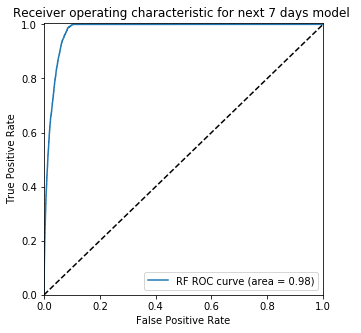

In [183]:
# Plot ROC in one graph
y_hat_7 = rf_7.predict_proba(X_val.iloc[:,1:])[:,1]
fpr_rf, tpr_rf, _rf = roc_curve(y_val['user_purchase_binary_7_days'], y_hat_7)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 7 days model ')
plt.legend(loc="lower right")
plt.show()

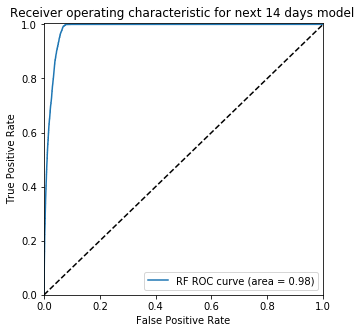

In [184]:
# Plot ROC in one graph
y_hat_14 = rf_14.predict_proba(X_val.iloc[:,1:])[:,1]
fpr_rf, tpr_rf, _rf = roc_curve(y_val['user_purchase_binary_14_days'], y_hat_14)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 14 days model ')
plt.legend(loc="lower right")
plt.show()

             Feature importance of Random Forest Model (7 days)


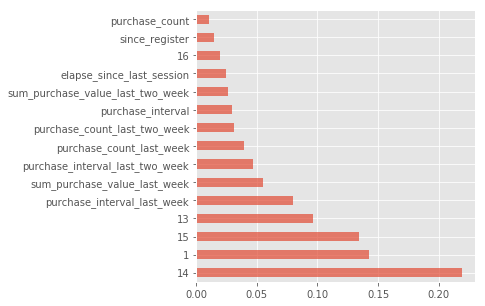

In [207]:
# Check feature importance and display in bar plot.

print('             Feature importance of Random Forest Model (7 days)')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf_7.feature_importances_, index=X_train.columns[1:])
feat_importances.nlargest(15).plot(kind='barh', alpha=0.7)
plt.show()

             Feature importance of Random Forest Model (14 days)


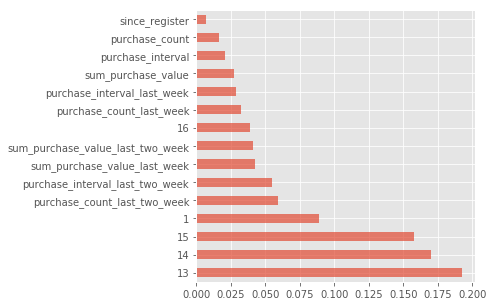

In [206]:
# Check feature importance and display in bar plot.

print('             Feature importance of Random Forest Model (14 days)')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf_14.feature_importances_, index=X_train.columns[1:])
feat_importances.nlargest(15).plot(kind='barh', alpha=0.7)
plt.show()

### predict

In [185]:
submission = pd.read_csv('../Data/sample_submission_2.csv')

In [186]:
events_pred = get_training_data(events, submission)
sessions_pred = get_training_data(sessions, submission)

In [187]:
X_pred = compute_features(events_pred, sessions_pred, key_attr)

In [188]:
X_pred.head()

,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,...,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week,1,13,14,15,16
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.441477,0.219348,0.030461,0.924145,4.518048,3.654081,1.283193,1.552283,-0.053125,...,-1.892289,-0.564582,-0.892446,-1.842897,-1.484856,3.240703,3.295367,3.297755,3.683200,3.598436
1,000059859ec188af6035870faf885c3038cedda05b3a54...,-0.053697,-0.122268,-0.143104,-0.073329,-0.187696,-0.234003,0.452875,-0.019483,-0.053125,...,-0.927795,-1.297924,-1.001589,0.250443,0.326989,-0.109338,-0.037368,-0.037070,0.027026,-0.042594
2,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,-0.256374,-0.122268,-0.143104,-0.333810,-0.187696,-0.234003,-0.344722,-0.120609,-0.053125,...,-0.892998,-1.301366,-0.972964,0.250443,0.326989,-0.109338,-0.089247,-0.086988,-0.087230,-0.088107
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,-0.156948,-0.122268,-0.143104,-0.311196,-0.187696,-0.234003,-0.297002,-0.120609,-0.053125,...,-1.120403,-1.505182,-0.997060,0.250443,0.326989,-0.109338,-0.089247,-0.086988,-0.087230,-0.088107
4,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,-0.240051,-0.122268,-0.143104,-0.132510,-0.187696,-0.234003,0.146107,-0.120609,-0.053125,...,-0.025502,0.114124,-0.672629,0.250443,0.326989,-0.109338,-0.089247,-0.086988,-0.087230,-0.088107


In [189]:
X_pred['pred_7'] = rf_7.predict_proba(X_pred.iloc[:,1:])[:,1]
X_pred['pred_14'] = rf_14.predict_proba(X_pred.iloc[:,1:-1])[:,1]

In [190]:
pred_7 = X_pred[['user_id_hash','pred_7']]
pred_14 = X_pred[['user_id_hash','pred_14']]

In [191]:
submit = submission.copy()
submit = submit.merge(pred_7, how='left', on='user_id_hash').merge(pred_14, how='left', on='user_id_hash').fillna(0)

In [192]:
submit = submit.drop(['user_purchase_binary_7_days', 'user_purchase_binary_14_days'],axis=1)

In [193]:
submit = submit.rename(columns={'pred_7':'user_purchase_binary_7_days', 'pred_14':'user_purchase_binary_14_days'})

In [194]:
submit.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.017246,0.040978
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.261977,0.265889
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.017246,0.040978
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.017246,0.041251
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.017246,0.040978


In [195]:
submit.to_csv('submit/add_attr_2.csv', index=False)

In [196]:
len(submit)

312568